
#Drought Identification and Trend Analysis using Google Earth Engine (GEE) - Admin 1 Level

Author - Samuel Gartenstein

Date - Oct 2024

Version - 1.0


In [3]:
#pip install pymannkendall

In [4]:
import ee
import geemap
import numpy as np
import pandas as pd
from scipy.stats import gamma, norm, kstest, probplot
import time
import matplotlib.pyplot as plt
from ipywidgets import interact, Dropdown
import pymannkendall as mk

In [5]:
# Initialize Google Earth Engine
def initialize_ee():
    ee.Authenticate()
    ee.Initialize(project='ee-sg4283') #Change it to your project ID

initialize_ee()


### Define Analysis Boundaries

We use the following crop calendar to select the regions and time periods to focus on.

We define boundaries for the Western and Rift Valley, and Eastern and Northern Kenya. We use the FAO GAUL: Global Administrative Unit Layers for the analysis.

The Global Administrative Unit Layers (GAUL) compiles and disseminates the best available information on administrative units for all the countries in the world, providing a contribution to the standardization of the spatial dataset representing administrative units. The GAUL always maintains global layers with a unified coding system at country, first (e.g. departments), and second administrative levels (e.g. districts). Where data is available, it provides layers on a country by country basis down to third, fourth, and lowers levels.

**Note to self**: Add in clickable links


In [6]:
# Load the FAO GAUL dataset for Zambia at administrative level 1
admin_level = 'level1'
country_name = 'Zambia'
roi = ee.FeatureCollection(f"FAO/GAUL/2015/{admin_level}")
roi = roi.filter(ee.Filter.eq('ADM0_NAME', country_name))

# Print the available counties (ADM1_NAME) for verification
counties_list = roi.aggregate_array('ADM1_NAME').getInfo()
print(counties_list)

['Central', 'Copperbelt', 'Eastern', 'Luapula', 'Lusaka', 'North-Western', 'Northern', 'Southern', 'Western']


In [7]:
# Creating a map centered on Zambia
m = geemap.Map()
m.setCenter(27.8493, -13.1339, 6)  # Longitude, Latitude, and zoom level

# Add Zambia's Admin 1 boundaries as a layer
m.addLayer(roi, {"color": "green"}, "Zambia Admin 1 Boundaries")

# Display the map
m


Map(center=[-13.1339, 27.8493], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=SearchD…

# Load CHIRPS Pentad Dataset


In [82]:
def fetch_precipitation_data(region_name):
    """
    Fetch monthly precipitation data for a given Admin Level 1 region in Zambia for 2022 to 2023,
    and return a restructured DataFrame with the following columns:
    - year, month, date, region, admin1_name, precipitation.
    """
    chirps = ee.ImageCollection('UCSB-CHG/CHIRPS/DAILY')
    startyear, endyear = 2000, 2023  # Update to the years 2022 to 2023
    startdate, enddate = ee.Date.fromYMD(startyear, 1, 1), ee.Date.fromYMD(endyear, 12, 31)

    # Define the region from Zambia (Admin Level 1)
    region = ee.FeatureCollection('FAO/GAUL/2015/level1') \
              .filter(ee.Filter.eq('ADM0_NAME', 'Zambia')) \
              .filter(ee.Filter.eq('ADM1_NAME', region_name)).first()

    def MonthlySum(year):
        """
        Sum precipitation data for each month of a given year.
        """
        def monthSum(month):
            # Filter the CHIRPS dataset for the specific month and year
            monthly_sum = chirps.filterDate(startdate, enddate) \
                                .filter(ee.Filter.calendarRange(year, year, 'year')) \
                                .filter(ee.Filter.calendarRange(month, month, 'month')) \
                                .sum() \
                                .reduceRegion(ee.Reducer.mean(), geometry=region.geometry(), scale=5000, maxPixels=1e8)

            # Return the precipitation data and additional info
            return ee.Feature(None, {
                'year': year,
                'month': month,
                'date': ee.Date.fromYMD(year, month, 1).format(),
                'region': 'Zambia',  # Set as Zambia
                'admin1_name': region_name,  # Admin Level 1 region name
                'precipitation': monthly_sum.get('precipitation')
            })
        return ee.List.sequence(1, 12).map(monthSum)

    # List of years from 2022 to 2023
    years = ee.List.sequence(startyear, endyear)

    # Map over the years and fetch monthly precipitation
    monthlyPrecip = years.map(MonthlySum).flatten()

    # Convert the result to a FeatureCollection
    monthlyPrecipCollection = ee.FeatureCollection(monthlyPrecip)

    # Retrieve the result on the client side as a dictionary
    properties_list = monthlyPrecipCollection.getInfo()

    # Convert the result to a pandas DataFrame
    if properties_list['features']:
        data = [feature['properties'] for feature in properties_list['features']]
        df = pd.DataFrame(data)
    else:
        df = pd.DataFrame()

    # Define the restructure function inside the fetch function
    def restructure_dataframe(df):
        """
        Restructure the DataFrame to match the desired column order:
        ['year', 'month', 'date', 'region', 'admin1_name', 'precipitation']
        """
        desired_order = ['year', 'month', 'date', 'region', 'admin1_name', 'precipitation']
        df = df[desired_order]  # Ensure all columns are present in the DataFrame
        return df

    # Call the restructure function and return the restructured DataFrame
    return restructure_dataframe(df)



In [91]:
# Fetch and store each region's DataFrame in individual variables
central_precip_data = fetch_precipitation_data('Central')
print(central_precip_data.head(12))
print(central_precip_data.tail(12))

    year  month                 date  region admin1_name  precipitation
0   2000      1  2000-01-01T00:00:00  Zambia     Central     240.545614
1   2000      2  2000-02-01T00:00:00  Zambia     Central     255.378366
2   2000      3  2000-03-01T00:00:00  Zambia     Central     232.452149
3   2000      4  2000-04-01T00:00:00  Zambia     Central       9.756547
4   2000      5  2000-05-01T00:00:00  Zambia     Central       0.499351
5   2000      6  2000-06-01T00:00:00  Zambia     Central       0.000000
6   2000      7  2000-07-01T00:00:00  Zambia     Central       0.000000
7   2000      8  2000-08-01T00:00:00  Zambia     Central       0.018995
8   2000      9  2000-09-01T00:00:00  Zambia     Central       0.002573
9   2000     10  2000-10-01T00:00:00  Zambia     Central      10.420805
10  2000     11  2000-11-01T00:00:00  Zambia     Central     119.177322
11  2000     12  2000-12-01T00:00:00  Zambia     Central     223.681583
     year  month                 date  region admin1_name  preci

In [90]:
copperbelt_precip_data = fetch_precipitation_data('Copperbelt')
print(copperbelt_precip_data.head(12))
print(copperbelt_precip_data.tail(12))

    year  month                 date  region admin1_name  precipitation
0   2000      1  2000-01-01T00:00:00  Zambia  Copperbelt     294.234393
1   2000      2  2000-02-01T00:00:00  Zambia  Copperbelt     257.580622
2   2000      3  2000-03-01T00:00:00  Zambia  Copperbelt     262.668946
3   2000      4  2000-04-01T00:00:00  Zambia  Copperbelt      12.032647
4   2000      5  2000-05-01T00:00:00  Zambia  Copperbelt       0.000000
5   2000      6  2000-06-01T00:00:00  Zambia  Copperbelt       0.000000
6   2000      7  2000-07-01T00:00:00  Zambia  Copperbelt       0.000000
7   2000      8  2000-08-01T00:00:00  Zambia  Copperbelt       0.002427
8   2000      9  2000-09-01T00:00:00  Zambia  Copperbelt       0.008651
9   2000     10  2000-10-01T00:00:00  Zambia  Copperbelt      20.584498
10  2000     11  2000-11-01T00:00:00  Zambia  Copperbelt     154.918555
11  2000     12  2000-12-01T00:00:00  Zambia  Copperbelt     330.657782
     year  month                 date  region admin1_name  preci

In [89]:
luapula_precip_data = fetch_precipitation_data('Luapula')
print(luapula_precip_data.head(12))
print(luapula_precip_data.tail(12))

    year  month                 date  region admin1_name  precipitation
0   2000      1  2000-01-01T00:00:00  Zambia     Luapula     247.144670
1   2000      2  2000-02-01T00:00:00  Zambia     Luapula     214.376241
2   2000      3  2000-03-01T00:00:00  Zambia     Luapula     274.729209
3   2000      4  2000-04-01T00:00:00  Zambia     Luapula      52.603046
4   2000      5  2000-05-01T00:00:00  Zambia     Luapula       1.138437
5   2000      6  2000-06-01T00:00:00  Zambia     Luapula       0.000000
6   2000      7  2000-07-01T00:00:00  Zambia     Luapula       0.000187
7   2000      8  2000-08-01T00:00:00  Zambia     Luapula       0.059572
8   2000      9  2000-09-01T00:00:00  Zambia     Luapula       1.191195
9   2000     10  2000-10-01T00:00:00  Zambia     Luapula      28.071444
10  2000     11  2000-11-01T00:00:00  Zambia     Luapula     171.096062
11  2000     12  2000-12-01T00:00:00  Zambia     Luapula     282.562261
     year  month                 date  region admin1_name  preci

In [88]:
lusaka_precip_data = fetch_precipitation_data('Lusaka')
print(lusaka_precip_data.head(12))
print(lusaka_precip_data.tail(12))

    year  month                 date  region admin1_name  precipitation
0   2000      1  2000-01-01T00:00:00  Zambia      Lusaka     211.499932
1   2000      2  2000-02-01T00:00:00  Zambia      Lusaka     229.132062
2   2000      3  2000-03-01T00:00:00  Zambia      Lusaka     181.584246
3   2000      4  2000-04-01T00:00:00  Zambia      Lusaka      10.481713
4   2000      5  2000-05-01T00:00:00  Zambia      Lusaka       0.242372
5   2000      6  2000-06-01T00:00:00  Zambia      Lusaka       0.000000
6   2000      7  2000-07-01T00:00:00  Zambia      Lusaka       0.000000
7   2000      8  2000-08-01T00:00:00  Zambia      Lusaka       0.005142
8   2000      9  2000-09-01T00:00:00  Zambia      Lusaka       0.006372
9   2000     10  2000-10-01T00:00:00  Zambia      Lusaka      11.540079
10  2000     11  2000-11-01T00:00:00  Zambia      Lusaka      96.909930
11  2000     12  2000-12-01T00:00:00  Zambia      Lusaka     165.467175
     year  month                 date  region admin1_name  preci

In [92]:
north_western_precip_data = fetch_precipitation_data('North-Western')
print(north_western_precip_data.head(12))
print(north_western_precip_data.tail(12))

    year  month                 date  region    admin1_name  precipitation
0   2000      1  2000-01-01T00:00:00  Zambia  North-Western     204.452954
1   2000      2  2000-02-01T00:00:00  Zambia  North-Western     198.768892
2   2000      3  2000-03-01T00:00:00  Zambia  North-Western     208.330116
3   2000      4  2000-04-01T00:00:00  Zambia  North-Western      14.904502
4   2000      5  2000-05-01T00:00:00  Zambia  North-Western       0.828444
5   2000      6  2000-06-01T00:00:00  Zambia  North-Western       0.000000
6   2000      7  2000-07-01T00:00:00  Zambia  North-Western       0.000015
7   2000      8  2000-08-01T00:00:00  Zambia  North-Western       0.064161
8   2000      9  2000-09-01T00:00:00  Zambia  North-Western       2.429160
9   2000     10  2000-10-01T00:00:00  Zambia  North-Western      26.123517
10  2000     11  2000-11-01T00:00:00  Zambia  North-Western     138.518985
11  2000     12  2000-12-01T00:00:00  Zambia  North-Western     264.346358
     year  month         

In [93]:
northern_precip_data = fetch_precipitation_data('Northern')
print(northern_precip_data.head(12))
print(northern_precip_data.tail(12))

    year  month                 date  region admin1_name  precipitation
0   2000      1  2000-01-01T00:00:00  Zambia    Northern     216.502658
1   2000      2  2000-02-01T00:00:00  Zambia    Northern     189.500853
2   2000      3  2000-03-01T00:00:00  Zambia    Northern     244.090929
3   2000      4  2000-04-01T00:00:00  Zambia    Northern      48.428260
4   2000      5  2000-05-01T00:00:00  Zambia    Northern       3.017012
5   2000      6  2000-06-01T00:00:00  Zambia    Northern       0.002201
6   2000      7  2000-07-01T00:00:00  Zambia    Northern       0.000000
7   2000      8  2000-08-01T00:00:00  Zambia    Northern       0.040952
8   2000      9  2000-09-01T00:00:00  Zambia    Northern       0.720938
9   2000     10  2000-10-01T00:00:00  Zambia    Northern      24.687120
10  2000     11  2000-11-01T00:00:00  Zambia    Northern     185.598424
11  2000     12  2000-12-01T00:00:00  Zambia    Northern     267.622248
     year  month                 date  region admin1_name  preci

In [94]:
southern_precip_data = fetch_precipitation_data('Southern')
print(southern_precip_data.head(12))
print(southern_precip_data.tail(12))

    year  month                 date  region admin1_name  precipitation
0   2000      1  2000-01-01T00:00:00  Zambia    Southern     170.279557
1   2000      2  2000-02-01T00:00:00  Zambia    Southern     241.883281
2   2000      3  2000-03-01T00:00:00  Zambia    Southern     146.443345
3   2000      4  2000-04-01T00:00:00  Zambia    Southern      16.081653
4   2000      5  2000-05-01T00:00:00  Zambia    Southern       0.563035
5   2000      6  2000-06-01T00:00:00  Zambia    Southern       0.000000
6   2000      7  2000-07-01T00:00:00  Zambia    Southern       0.000000
7   2000      8  2000-08-01T00:00:00  Zambia    Southern       0.000064
8   2000      9  2000-09-01T00:00:00  Zambia    Southern       0.032624
9   2000     10  2000-10-01T00:00:00  Zambia    Southern      12.328881
10  2000     11  2000-11-01T00:00:00  Zambia    Southern      76.468064
11  2000     12  2000-12-01T00:00:00  Zambia    Southern     176.965030
     year  month                 date  region admin1_name  preci

In [95]:
western_precip_data = fetch_precipitation_data('Western')
print(western_precip_data.head(12))
print(western_precip_data.tail(12))

    year  month                 date  region admin1_name  precipitation
0   2000      1  2000-01-01T00:00:00  Zambia     Western     186.183187
1   2000      2  2000-02-01T00:00:00  Zambia     Western     196.745684
2   2000      3  2000-03-01T00:00:00  Zambia     Western     218.633670
3   2000      4  2000-04-01T00:00:00  Zambia     Western      17.662483
4   2000      5  2000-05-01T00:00:00  Zambia     Western       0.080743
5   2000      6  2000-06-01T00:00:00  Zambia     Western       0.000000
6   2000      7  2000-07-01T00:00:00  Zambia     Western       0.000002
7   2000      8  2000-08-01T00:00:00  Zambia     Western       0.000036
8   2000      9  2000-09-01T00:00:00  Zambia     Western       0.267395
9   2000     10  2000-10-01T00:00:00  Zambia     Western      14.932101
10  2000     11  2000-11-01T00:00:00  Zambia     Western      67.325252
11  2000     12  2000-12-01T00:00:00  Zambia     Western     197.707636
     year  month                 date  region admin1_name  preci

In [105]:
# Combine all three DataFrames into a single DataFrame
combined_df = pd.concat([
    central_precip_data,
    copperbelt_precip_data,
    luapula_precip_data,
    lusaka_precip_data,
    north_western_precip_data,
    northern_precip_data,
    southern_precip_data,
    western_precip_data
])

'''
TO DO: Export as CSV
'''


' \nTO DO: Export as CSV\n'

### Filtering for Rain Season

In the analysis, we are only interested in examining rainfall seasons. In Zambia, this takes place between November and March. As a result, I will filter `combined_df`.

In [106]:
# Filter combined_df to include only months from November (11) to March (3)
zambia_rain_df = combined_df[combined_df['month'].isin([11, 12, 1, 2, 3])]

# Print the filtered combined DataFrame
print(zambia_rain_df.head(12))
print(zambia_rain_df.tail(12))


    year  month                 date  region admin1_name  precipitation
0   2000      1  2000-01-01T00:00:00  Zambia     Central     240.545614
1   2000      2  2000-02-01T00:00:00  Zambia     Central     255.378366
2   2000      3  2000-03-01T00:00:00  Zambia     Central     232.452149
10  2000     11  2000-11-01T00:00:00  Zambia     Central     119.177322
11  2000     12  2000-12-01T00:00:00  Zambia     Central     223.681583
12  2001      1  2001-01-01T00:00:00  Zambia     Central     263.590931
13  2001      2  2001-02-01T00:00:00  Zambia     Central     330.130325
14  2001      3  2001-03-01T00:00:00  Zambia     Central     216.453090
22  2001     11  2001-11-01T00:00:00  Zambia     Central     122.278114
23  2001     12  2001-12-01T00:00:00  Zambia     Central     198.752585
24  2002      1  2002-01-01T00:00:00  Zambia     Central     170.267318
25  2002      2  2002-02-01T00:00:00  Zambia     Central     102.782122
     year  month                 date  region admin1_name  preci

## Add in Description of SPI

In [107]:
# Checking if all precipitation values are positive in each dataset
print("Zambia Rainy Season: All values positive? ", (zambia_rain_df['precipitation'] > 0).all())

Zambia Rainy Season: All values positive?  True


### Histogram

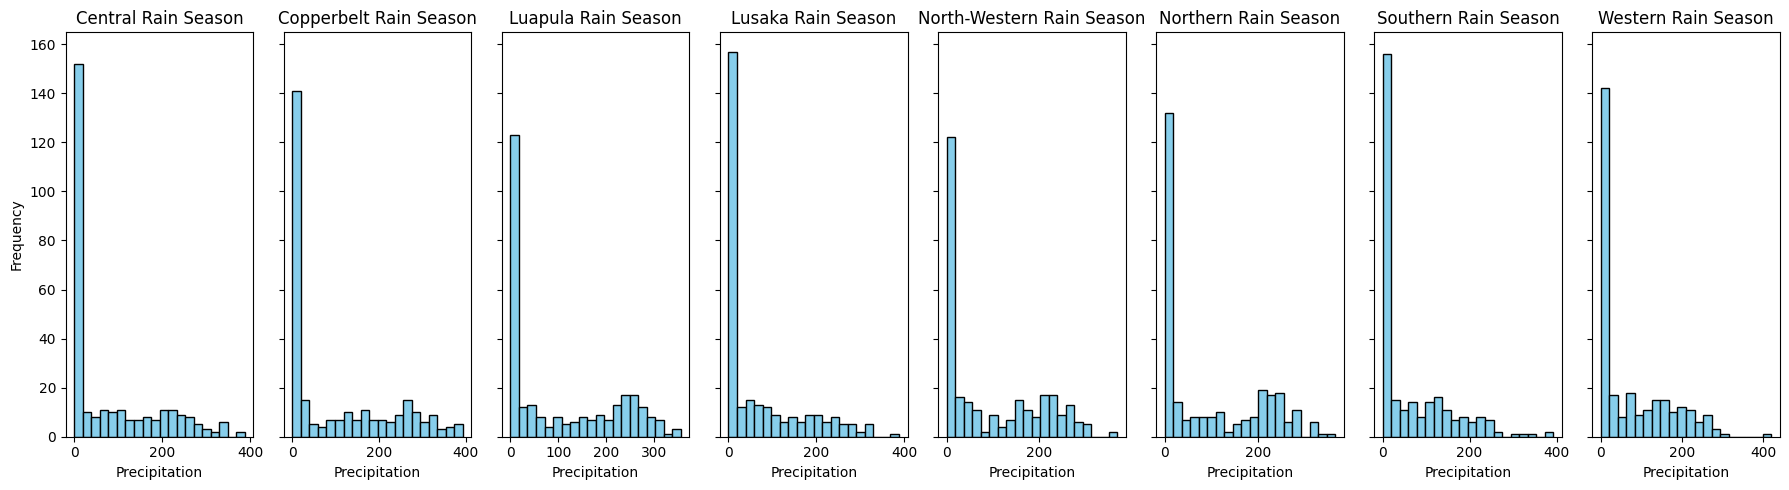

In [108]:
# Get the list of unique Admin Level 1 regions (admin1_name) from the DataFrame
regions = combined_df['admin1_name'].unique()

# Set up the plot with one subplot per region (adjust rows and cols based on number of regions)
fig, axes = plt.subplots(1, len(regions), figsize=(18, 5), sharey=True)

# Loop through each region and plot the histogram
for i, region in enumerate(regions):
    # Filter the data for the current region
    region_data = combined_df[combined_df['admin1_name'] == region]

    # Plot histogram for the current region
    axes[i].hist(region_data['precipitation'], bins=20, color='skyblue', edgecolor='black')
    axes[i].set_title(f'{region} Rain Season')
    axes[i].set_xlabel('Precipitation')

    # Set ylabel only on the first plot
    if i == 0:
        axes[i].set_ylabel('Frequency')

# Adjust layout to prevent overlapping
plt.tight_layout()

# Show the plots
plt.show()

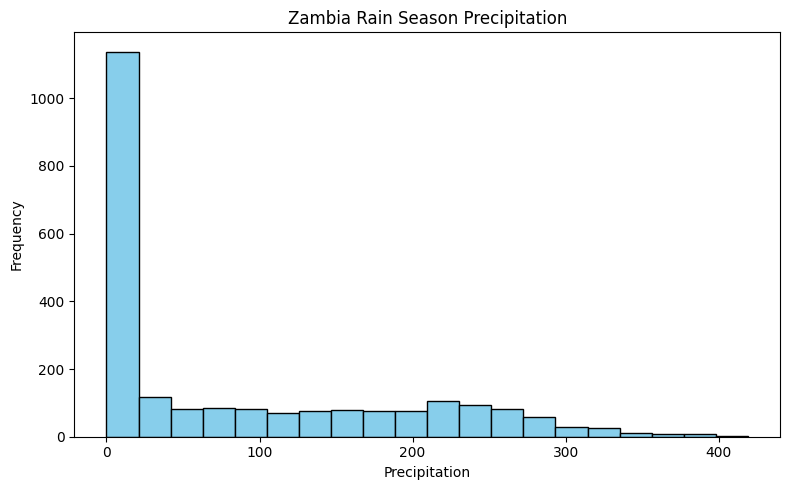

In [109]:
# Plot histogram for all of Zambia
plt.figure(figsize=(8, 5))
plt.hist(combined_df['precipitation'], bins=20, color='skyblue', edgecolor='black')
plt.title('Zambia Rain Season Precipitation')
plt.xlabel('Precipitation')
plt.ylabel('Frequency')

# Show the plot
plt.tight_layout()
plt.show()
